In [1]:
from glob import glob
from os import listdir
from framed import load_cbmodel
import pandas as pd
from framed.io.sbml import sanitize_id
import reframed
from reframed.cobra.ensemble import load_ensemble
import cobra
from cobra.io import read_sbml_model
from operator import itemgetter
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from cobra.medium import minimal_medium

# Heatmap with models' media composition

In [5]:
class MediumComposition:
    """Composition of media.
    
    Parameters
    ----------
    StrainName: str, default=None
        Must be the initial of the genus,
        followed by the specific term of the species
        (e.g. Bacteroides thetaiotaomicron -> Bthetaiotaomicron)

    Template: list, {"universal", "gram"}, default=None
    GapProcess: list, {"gapAfter", "gapDuring", "NoGap"}, default=None
    Medium: list, {"M9", "LB", "NoMedium"}, default=None

    CuratedModel: str, {"curated"}, default=None
        If a curated model exists, the file must have 
        "curated" in the name
    """
    
    def __init__(self, StrainName=None,Template=None, GapProcess=None, Medium=None, *, CuratedModel=None):
        self.StrainName=StrainName
        self.Template=Template
        self.GapProcess=GapProcess
        self.Medium=Medium
        self.CuratedModel=CuratedModel
    
    def getFilesNamesList(self):
        '''Returns a list of filenames from models
        with **same Template and same GapProcess**
        and from curated models
        
        fileName example: "Bthetaiotaomicron_gram_gapAfter_M9.xml.gz"
        '''
    
        filesNamesList=[]
        Files = '*.xml.gz'
        carvemeVars=[self.StrainName, self.Template, self.GapProcess, self.Medium]
        if all(carvemeVar is not None for carvemeVar in carvemeVars): #if none of these is None
            for fileName in glob(Files):
                if "Ensemble" not in fileName:
                    if self.StrainName in fileName:
                        for template in self.Template:
                            if template in fileName:
                                for gapP in self.GapProcess:
                                    if gapP in fileName:
                                        for medium in self.Medium:
                                            if medium in fileName:
                                                filesNamesList.append(fileName)
        CuratedFiles = '*.xml'
        curatedVars=[self.StrainName, self.CuratedModel]
        if all(curatedVar is not None for curatedVar in curatedVars):
            for curatedFileName in glob(CuratedFiles):
                if self.StrainName in curatedFileName:
                    if self.CuratedModel in curatedFileName:
                        filesNamesList.append(curatedFileName)
        return filesNamesList
    
    def modelMediumComposition(self):
        '''dataframe for each model medium composition
            except for curated models with LB and M9 media'''
        filesList=self.getFilesNamesList()
        if filesList: #if filesList is not empty, i.e., has at least one file name
            modelsDF = pd.DataFrame(columns=['mediumMetab']) 
            modelsDataframes=[]
            for fileName in filesList:
                model=read_sbml_model(fileName)  
                model.optimize()
                MediumL=[v for v in model.medium.keys()]
                ModelMediumData=[]
                for mediumMetab in MediumL:
                    ExReactionFlux=model.reactions.get_by_id(mediumMetab).flux
                    OneRow=[mediumMetab, ExReactionFlux]
                    ModelMediumData.append(OneRow)
                modelName=fileName.replace(".gz", '')
                modelName=modelName.replace(".xml", '')
                modelMediumDF=pd.DataFrame(ModelMediumData, columns=['mediumMetab', modelName]) 
                modelsDataframes.append(modelMediumDF)
            for each_DF in modelsDataframes:
                modelsDF=pd.merge(each_DF, modelsDF, on='mediumMetab', how='outer').fillna(0)
        else:
            modelsDF=None
                    
        return modelsDF
    
    def curatedMinimalMedium(self):
        '''makes series with minimal medium for curated model'''
        filesList=self.getFilesNamesList()
        if filesList: #if filesList is not empty, i.e., has at least one file name
            for fileName in filesList:
                if self.CuratedModel is not None:
                    if self.CuratedModel in fileName:
                        model=read_sbml_model(fileName)  
                        model.optimize()
                        #for M9 and LB, no oxygen
                        model.reactions.get_by_id('EX_o2(e)').bounds = (0.0, 1000.0)
                        model.optimize()
                        #function "minimal_medium" to get minimal medium [-O2] composition for curated model to grow
#                         M9Series=minimal_medium(model, 0.8, minimize_components=1, open_exchanges=False)
#                         M9Series.to_excel('BthetaCuratedMinimalMedium.xlsx')
                        M9Series=pd.read_excel('BthetaCuratedMinimalMedium.xlsx', index_col=0)
                        M9List=M9Series.index.tolist()
                        Media=pd.read_excel('carvemeMedia.xlsx')
                        M9CarvemeMedium=Media['M9'].tolist()
                        CarvemeM9Metabs=list(set(M9CarvemeMedium) - set(M9List))
                        self.M9Medium=M9List+CarvemeM9Metabs
                        LBmediumList=Media['LB'].tolist()
                        LBmedium=LBmediumList+self.M9Medium
                        self.LBmedium=list(set(LBmedium))
                        Media=[self.M9Medium, self.LBmedium]
                else:
                    Media=None

        return Media
    
    def curatedMediumComposition(self):
        filesList=self.getFilesNamesList()
        if filesList: #if filesList is not empty, i.e., has at least one file name
            modelsDF = pd.DataFrame(columns=['mediumMetab']) 
            modelsDataframes=[]
            for fileName in filesList:
                if self.CuratedModel is not None:
                    if self.CuratedModel in fileName:
                        Media=self.curatedMinimalMedium()
                        for medium in Media:
                            if medium == self.M9Medium:
                                mediumName="M9"
                            elif medium == self.LBmedium:
                                mediumName ="LB"
                            model=read_sbml_model(fileName)  
                            model.optimize()
                            MediumList=[v for v in model.medium.keys()] # has all Exchange reactions active
                            MediumList.remove("EX_glc(e)")
                            model.reactions.get_by_id('EX_o2(e)').bounds = (0.0, 1000.0)
                            for mediumRx in MediumList: #go through each reaction in medium
                                if mediumRx not in medium: #put the rxs that are not in M9 composition as inactive so that we have M9 medium
                                    model.reactions.get_by_id(mediumRx).bounds = (0.0, 1000.0) #put the flux as INACTIVE
                            for Ex_rx in model.medium.keys():
                                model.reactions.get_by_id(Ex_rx).lower_bound = -10
                                model.reactions.get_by_id(Ex_rx).upper_bound = 1000
                            FBAsolution=model.optimize()
                            rxFluxesSeries=FBAsolution.fluxes
                            rxFluxesDF=pd.DataFrame(rxFluxesSeries, columns=['fluxes'])
                            MediumL=[v for v in model.medium.keys()]   
                            ExRxsFluxesDF=rxFluxesDF[rxFluxesDF.index.isin(MediumL)]
                            ModelMediumData=[]
#                             for index, row in df.iterrows():
#                                 print(row['c1'], row['c2'])
                            for index,row in ExRxsFluxesDF.iterrows():
                                ExReactionFlux=row['fluxes']
                                mediumMetab=index.replace("(e)", "_e")
        
#                                 ExReactionFlux=model.reactions.get_by_id(mediumMetab).flux
#                                 mediumMetab=mediumMetab.replace("(e)", "_e")
                                OneRow=[mediumMetab, ExReactionFlux]
                                ModelMediumData.append(OneRow)
                            modelName=fileName.replace(".xml", '')
                            modelMediumDF=pd.DataFrame(ModelMediumData, columns=['mediumMetab', modelName + mediumName]) 
                            modelsDataframes.append(modelMediumDF)
                for each_DF in modelsDataframes:
                    modelsDF=pd.merge(each_DF, modelsDF, on='mediumMetab', how='outer').fillna(0)
        else:
            modelsDF=None
                    
        return modelsDF
        
    def joinDataframes(self):
        '''Joins carveme models table with curated models one
        '''
        jointDF = pd.DataFrame(columns=['mediumMetab']) 
        generalmodelsDF=self.modelMediumComposition()
        curatedDF=self.curatedMediumComposition()
        dataframes=[generalmodelsDF, curatedDF]
            
        if all(df is not None for df in dataframes): #if none of the dataframes is None
            for df in dataframes:
                jointDF=pd.merge(df, jointDF, on='mediumMetab', how='outer').fillna(0)
            self.jointDF=jointDF.set_index('mediumMetab')
            
        elif all(df is None for df in dataframes): #if all dataframes are None
            self.jointDF=pd.DataFrame() #empty dataframe
            
        elif generalmodelsDF is None:
            jointDF=curatedDF
            self.jointDF=jointDF
            
        elif curatedDF is None:
            jointDF=generalmodelsDF
            self.jointDF=jointDF
            
        return self.jointDF  

In [6]:
def mediumHeatmap(df):
    
    plt.figure(figsize = (2,10))

    s=sns.heatmap(df,cmap="Blues", xticklabels=True, yticklabels=True, cbar_kws={'label': 'Exchange reaction flux \n (0 = no flux/not present)', 'location': 'top'}, linewidths=0.5, annot=True)
#     plt.savefig('m9Fluxes_Heatmap.png',bbox_inches="tight")
    
    return s

In [7]:
# x=MediumComposition(StrainName="Bthetaiotaomicron",Template=['gram'],GapProcess=['gapAfter'], Medium=['LB', 'M9'])
# x.joinDataframes()
# x.mediumHeatmap()

x=MediumComposition(StrainName="Bthetaiotaomicron",Template=['gram'],GapProcess=['gapAfter'], Medium=['M9'], CuratedModel="curated")
df=x.joinDataframes()

<AxesSubplot:ylabel='mediumMetab'>

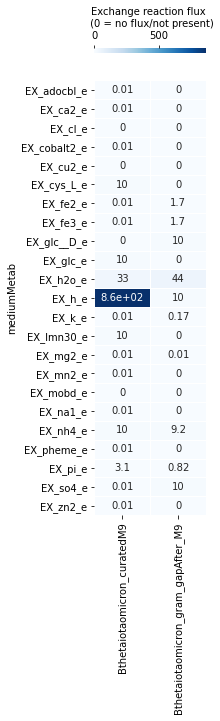

In [8]:
#glucose has a D in carveme models -> change this in curated?
dfsliced=df.copy()
# dfsliced=dfsliced.round(2)
dfslicedColumns=dfsliced[["Bthetaiotaomicron_curatedM9", "Bthetaiotaomicron_gram_gapAfter_M9"]]
dfsliced=dfslicedColumns.reset_index()
dfslicedCol=dfsliced[["Bthetaiotaomicron_curatedM9", "Bthetaiotaomicron_gram_gapAfter_M9"]]
indexList=[]
for index, row in dfslicedCol.iterrows():
    rowDF=dfslicedCol.iloc[[index]]
    rowValues=row.values.tolist()
    res = any(val != 0.00000 for val in rowValues)
    if res: #if p<0.05 for at least one cancer subtype 
        indexList.append(index)
        
dfsliced=dfsliced[dfsliced.index.isin(indexList)]
# dfsliced['RowTotal'] = dfsliced.sum(axis=1)
# dfsliced=dfsliced[dfsliced['RowTotal'] !=0]
# dfsliced=dfsliced.drop(columns=['RowTotal'])
dfsliced=dfsliced.set_index(['mediumMetab'])
dfsliced = dfsliced.append(dfslicedColumns.loc['EX_mobd_e']) 
dfsliced=dfsliced.sort_index(ascending=True)
dfsliced=dfsliced.round(2)
# dfsliced
hm=mediumHeatmap(dfsliced.abs())
hm